# Import dependencies

In [1]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [2]:
# pdb will automatically run on exceptions
#%pdb on # currently not working due to https://github.com/ipython/ipykernel/issues/422

In [3]:
# import os

# # Only occupy one GPU, as in https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# # Only allocate GPU memory as needed
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# # Suppress tf warning messages
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [4]:
%matplotlib inline
from sgm.dependencies import *

# Initialize untrained agent

In [5]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.enable_eager_execution(config=config)

In [6]:
#tf.debugging.set_log_device_placement(True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [8]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent

# If you change the environment parameters below, make sure to run
# tf.reset_default_graph() in the cell above before training.
max_episode_steps = 20
env_name = 'FourRooms'  # Choose one of the environments shown above. 
resize_factor = 5  # Inflate the environment to increase the difficulty.
thin = True # If True, resize by expanding open space, not walls, to make walls thin
desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
model_dir = os.path.join(base_dir, desc_name)

tf_env = env_load_fn(env_name, max_episode_steps,
                     resize_factor=resize_factor,
                     terminate_on_timeout=False,
                     thin=thin)
eval_tf_env = env_load_fn(env_name, max_episode_steps,
                          resize_factor=resize_factor,
                          terminate_on_timeout=True,
                          thin=thin)

agent = UvfAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    max_episode_steps=max_episode_steps,
    use_distributional_rl=True,
    ensemble_size=3)

/home/xh/miniconda3/envs/keras/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
print(tf_env.time_step_spec())
print(tf_env)

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=OrderedDict([('goal', BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/goal', minimum=array(0., dtype=float32), maximum=array(55., dtype=float32))), ('observation', BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation/observation', minimum=array(0., dtype=float32), maximum=array(55., dtype=float32)))]))


# Train the agent

In [10]:
# from sgm.trainer import train_eval

# train_eval(agent,
#           tf_env,
#           eval_tf_env,
#           initial_collect_steps=1000,
#           eval_interval=1000,
#           num_eval_episodes=10,
#           num_iterations=30000,
#           save_model_dir=model_dir,
#           experiment_name=f"{env_name}_coordinate_{max_episode_steps}steps")

# Load trained model into agent

In [11]:
filename = "FourRooms_coordinate_20steps-Dec-05-2019-12-58-28-PM/ckpt/"
checkpoint_file = os.path.join(model_dir, filename)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

# Fill replay buffer with random prefectly explored data

In [12]:
from sgm.envs import *

#@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=0.0,
    min_dist=0,
    max_dist=np.inf)
rb_vec = []
for it in range(replay_buffer_size):
    ts = eval_tf_env.reset()
    print(ts.observation["goal"].numpy()[0])
    rb_vec.append(ts.observation['observation'].numpy()[0])
rb_vec = np.array(rb_vec)

[0.28724554 0.5689905 ]
[0.5564802  0.35661793]
[0.76734513 0.01091196]
[0.9058868  0.22127496]
[0.15115164 0.77229553]
[0.8124155 0.3281961]
[0.21662126 0.25868508]
[0.4541014 0.7515504]
[0.41702995 0.09533265]
[0.5134896  0.60847384]
[0.58474874 0.311783  ]
[0.4498826 0.7049422]
[0.77005315 0.36845595]
[0.09758558 0.6718059 ]
[0.53442425 0.6584662 ]
[0.12333792 0.7520168 ]
[0.29294828 0.62684786]
[0.03164306 0.36696228]
[0.7444531  0.05585807]
[0.9219154  0.33864704]
[0.2979913  0.30723017]
[0.9577023 0.3965834]
[0.8529099  0.08050305]
[0.83623207 0.8961334 ]
[0.6386685  0.68703425]
[0.9031492 0.738227 ]
[0.96103716 0.7217799 ]
[0.94801456 0.20868291]
[0.02762009 0.22968248]
[0.3954158 0.5875141]
[0.50468785 0.9907871 ]
[0.4814142  0.33382338]
[0.8651669 0.5351948]
[0.79648316 0.44216055]
[0.95897233 0.566941  ]
[0.6754588 0.5128776]
[0.40225935 0.6821889 ]
[0.6906488  0.54418135]
[0.8536405 0.5083562]
[0.28905007 0.40205628]
[0.402368  0.7453145]
[0.04354376 0.8784587 ]
[0.05764781 

[0.47204977 0.7925325 ]
[0.22317135 0.07461257]
[0.11205535 0.10823117]
[0.9471479 0.9763328]
[0.32060796 0.76201844]
[0.3314826  0.56645596]
[0.34313148 0.60618865]
[0.13989821 0.21466114]
[0.4097812  0.83851844]
[0.8398012  0.37169844]
[0.76586777 0.699989  ]
[0.61968154 0.3270868 ]
[0.63817966 0.31975463]
[0.79587156 0.7268915 ]
[0.41518015 0.06892934]
[0.9782157 0.6316931]
[0.8746615 0.7716221]
[0.34977373 0.14023969]
[0.2877023 0.996734 ]
[0.7414138  0.99095947]
[0.82029283 0.31673956]
[0.5365445  0.27502233]
[0.04860084 0.41261923]
[0.27594706 0.8643032 ]
[0.8498446  0.50874233]
[0.05950515 0.64663243]
[0.04956654 0.14106382]
[0.0141929 0.4052206]
[0.821053   0.13709034]
[0.48557138 0.309842  ]
[0.32761595 0.9721123 ]
[0.75099665 0.77975583]
[0.7058848  0.33312136]
[0.5116506 0.8801215]
[0.08971266 0.05588751]
[0.67564094 0.6721254 ]
[0.12757717 0.18154733]
[0.2863143  0.55033165]
[0.83277404 0.57459325]
[0.6914826  0.83939177]
[0.26647696 0.4429956 ]
[0.8740795  0.01752606]
[0.0

[0.28935167 0.6604538 ]
[0.84015125 0.49893913]
[0.8809313 0.4034007]
[0.35824043 0.07909799]
[0.17220247 0.7778164 ]
[0.20994376 0.2263467 ]
[0.69527626 0.02033859]
[0.23516914 0.09767195]
[0.4112677 0.8182656]
[0.8517475 0.8917081]
[0.47891682 0.8869327 ]
[0.63370997 0.87762874]
[0.5418098 0.872959 ]
[0.37371266 0.50043494]
[0.31225058 0.3459658 ]
[0.33889437 0.0103318 ]
[0.73839056 0.07094657]
[0.6175626  0.11797038]
[0.38092145 0.05925747]
[0.03923054 0.69510835]
[0.03858548 0.2112661 ]
[0.34542188 0.66399586]
[0.8720556 0.5213481]
[0.81122476 0.9432903 ]
[0.40056977 0.47415155]
[0.17188148 0.9475644 ]
[0.68382806 0.05723335]
[0.8015191  0.35745013]
[0.44617614 0.79038715]
[0.79048514 0.9466068 ]
[0.2944014  0.74032485]
[0.21120292 0.25777587]
[0.8852197  0.67682356]
[0.62888324 0.641765  ]
[0.34854546 0.35701045]
[0.7955955  0.14136022]
[0.1456126  0.49281573]
[0.02188571 0.7569006 ]
[0.92153615 0.25492442]
[0.07044459 0.5271803 ]
[0.03699109 0.18117695]
[0.3058574  0.00600286]
[0

[0.38248914 0.725375  ]
[0.6994363 0.9737014]
[0.49868858 0.16825445]
[0.11175934 0.44683614]
[0.26599336 0.8228019 ]
[0.24174011 0.13261822]
[0.17747723 0.6141349 ]
[0.38816068 0.22457384]
[0.60508585 0.51492226]
[0.85933405 0.94031197]
[0.9093325 0.9691113]
[0.88785225 0.98067963]
[0.6588909  0.62558615]
[0.36093858 0.9550611 ]
[0.63179755 0.9611497 ]
[0.29244006 0.35961112]
[0.04192317 0.89577115]
[0.7326903  0.86209655]
[0.8875801  0.53888655]
[0.08205343 0.00737931]
[0.19764037 0.31962568]
[0.4319427  0.28750247]
[0.89847416 0.38892147]
[0.2562432  0.19635758]
[0.60226154 0.680943  ]
[0.8389589  0.30948353]
[0.21772766 0.9552333 ]
[0.9460486  0.91129565]
[0.7988616 0.2695107]
[0.13564184 0.20818709]
[0.05337452 0.2491015 ]
[0.38015598 0.5640911 ]
[0.11780614 0.33810014]
[0.35018954 0.50022817]
[0.43144354 0.67425936]
[0.89566755 0.08817865]
[0.20390736 0.11359224]
[0.6726678  0.08720984]
[0.2269566 0.9742563]
[0.7979634  0.48051184]
[0.09919529 0.41478613]
[0.17099269 0.88785744]


[0.7528124 0.4805087]
[0.6635777  0.11494628]
[0.6757687  0.59649366]
[0.61625224 0.00812814]
[0.42546064 0.6406003 ]
[0.51053965 0.10711381]
[0.66997117 0.64419556]
[0.81919175 0.7222558 ]
[0.9948206  0.43166694]
[0.3859399  0.48711792]
[0.15014409 0.7904054 ]
[0.48977408 0.15289159]
[0.96880895 0.5660184 ]
[0.44004163 0.18461418]
[0.952655   0.86962515]
[0.0898241  0.88032615]
[0.67422163 0.00553648]
[0.1721437 0.6537833]
[0.44167376 0.3526917 ]
[0.8523939 0.9759146]
[0.37583753 0.5137125 ]
[0.16285162 0.71765125]
[0.9282923 0.6052956]
[0.22346751 0.27551314]
[0.20148961 0.61802554]
[0.00455236 0.5498526 ]
[0.31400645 0.27026033]
[0.22969148 0.29479766]
[0.89029294 0.7249301 ]
[0.08511795 0.65841407]
[0.26360568 0.7769311 ]
[0.25079247 0.14607689]
[0.06780633 0.06618581]
[0.89282405 0.48208508]
[0.6436842  0.48059544]
[0.41438267 0.78290147]
[0.05600507 0.37154365]
[0.43987402 0.04242171]
[0.4840079  0.93998504]
[0.8561545 0.973902 ]
[0.31463885 0.7255445 ]
[0.11591463 0.35155717]
[0

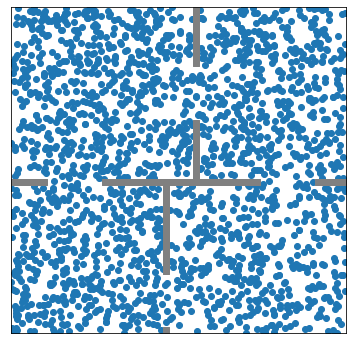

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(*rb_vec.T)
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
plt.show()

# Calculate qvalue distances

In [14]:
pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()
print(pdist)

[[[ 5.1838274 18.119057  13.967733  ... 19.161146  17.751595  19.141693 ]
  [10.723895   5.7872715  9.95074   ... 14.536355   9.356337  14.935171 ]
  [11.950335  18.631617   4.5770893 ... 19.015028  17.658777  19.798157 ]
  ...
  [18.192837  16.82066   16.140503  ...  4.728801  15.434275  19.11585  ]
  [11.980957  11.5590515 11.09517   ... 13.568579   5.0520077 17.20985  ]
  [13.075239  12.579233  16.638834  ... 17.754175  13.912204   4.043787 ]]

 [[ 5.539445  18.888285  11.194434  ... 19.133347  18.440094  19.460638 ]
  [10.602188   4.9890776  5.3846145 ... 14.157273   8.779366  14.033878 ]
  [14.072839  18.342705   4.0444813 ... 19.135458  17.286163  19.828026 ]
  ...
  [18.170536  16.879004  13.319894  ...  4.5543814 15.499174  19.236116 ]
  [12.407787  11.299335   6.650359  ... 13.888154   4.290284  16.700317 ]
  [11.501605  12.789      6.8621097 ... 15.751373  13.431865   4.9105864]]

 [[ 5.928726  17.564157  14.38715   ... 19.130457  17.509356  18.931528 ]
  [10.566749   5.37270

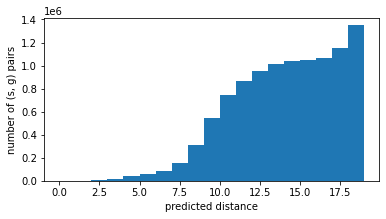

In [15]:
plt.figure(figsize=(6, 3))
plt.hist(pdist.flatten(), bins=range(20))
plt.xlabel('predicted distance')
plt.ylabel('number of (s, g) pairs')
plt.show()

# Tune edge cutoff

Plotting 229 nodes and 2321 edges


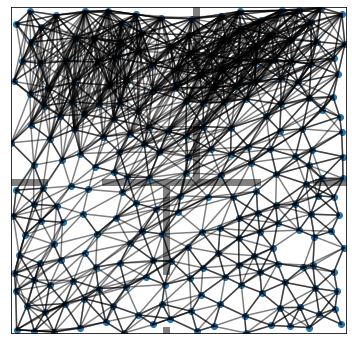

In [16]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

from sgm.utils.visualization import *
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 229 nodes and 1121 edges


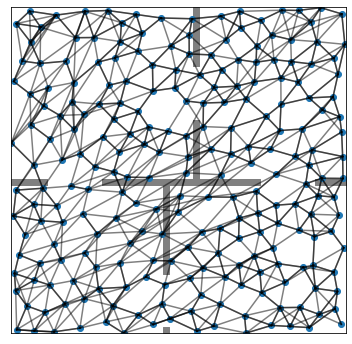

In [17]:
search_policy.keep_k_nearest(5)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 229 nodes and 910 edges


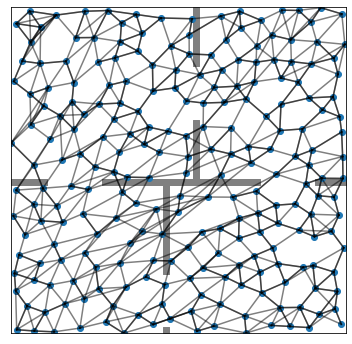

In [18]:
search_policy.keep_k_nearest(4)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 229 nodes and 685 edges


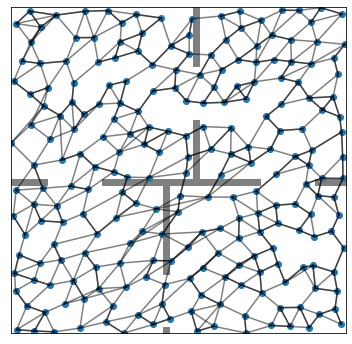

In [19]:
search_policy.keep_k_nearest(3)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 229 nodes and 458 edges


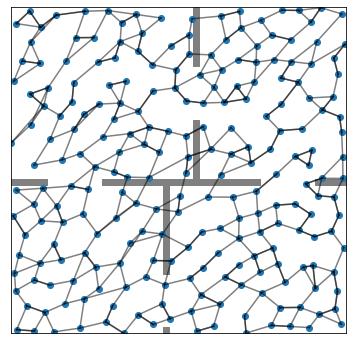

In [20]:
search_policy.keep_k_nearest(2)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 229 nodes and 229 edges


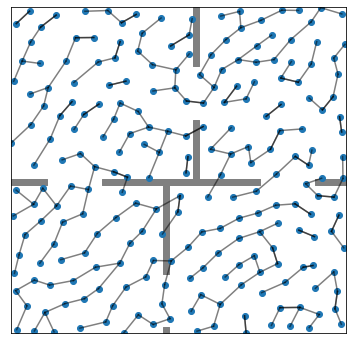

In [21]:
search_policy.keep_k_nearest(1)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

# Calculate Euclidean distances

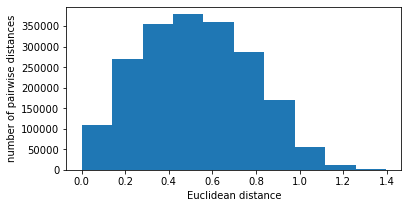

In [22]:
from scipy.spatial import distance
euclidean_dists = distance.pdist(rb_vec)

plt.figure(figsize=(6, 3))
plt.hist(euclidean_dists.flatten())
plt.xlabel('Euclidean distance')
plt.ylabel('number of pairwise distances')
plt.show()

# Initialize SGM search policy

In [23]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

# Cleanup and evaluate SGM

In [ ]:
from sgm.evaluation import cleanup_and_eval

logdir = os.path.join(os.getcwd(), os.pardir, "logs")
eval_difficulty = 0.95
k_nearest = 5
eval_trials = 20
total_cleanup_steps = 100000
eval_period = 5000

logfolder = cleanup_and_eval(search_policy,
                             search_policy_type,
                             desc_name,
                             eval_tf_env,
                             logdir,
                             eval_difficulty=eval_difficulty,
                             k_nearest=k_nearest,
                             eval_trials=eval_trials,
                             total_cleanup_steps=total_cleanup_steps,
                             eval_period=eval_period)

SGM has initial success rate 0.00
Evaluated initial SGM success rate in 609.71 seconds


# Load cleanup graphs

In [ ]:
from sgm.utils.visualization import *

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_initial"))
initial_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_0_cleanup_steps/"))
filtered_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_{}_cleanup_steps/".format(total_cleanup_steps)))
cleaned_graph = search_policy._g.copy()

pruned_graph = nx.difference(filtered_graph, cleaned_graph)

# Visualize cleanup graphs

In [ ]:
plot_points(search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(initial_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(filtered_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(cleaned_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(pruned_graph, search_policy.rb_vec, eval_tf_env)